In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import gzip, json
myfile = gzip.open(r'../data/all.json.gz')
items = json.load(myfile)
myfile.close()

In [3]:
print "Number of entries: %d " % len(items)

Number of entries: 92520 


### Example of an entry

In [4]:
import sympy
import pprint
sympy.pprint(items[100])


{author: aylak leydi, date_string: 15.02.2010 13:29, entry_no: 100, favcount: 
2, id: 18198550, page_no: 10, text: yürürken su içemiyorum.}


## Tokenizing

We can use regex with alphanumeric + extended Turkish Latin characters

In [5]:
import re

In [6]:
from collections import Counter
words_count = Counter()

In [7]:
for item in items:
    mytext = item['text']
    words = re.findall(ur'((?:\w|ö|ü|ı|ğ|ş|ç)+)', mytext)
    words = [w.strip() for w in words]
    words_count.update(words)

In [8]:
#Sort by frequency
words_items = sorted(words_count.items(), key=lambda tup:tup[1], reverse=True)
[words, wcount] = zip(*words_items)

In [9]:
from stop_words import get_stop_words
stopwords = set(get_stop_words('turkish'))

In [10]:
#Remove stopwords
words_items_filtered = [w for w in words_items if w[0] not in stopwords]
[words, wcount] = zip(*words_items_filtered)

In [11]:
authors_count = Counter([item['author'] for item in items])

In [12]:
authors_items = sorted(authors_count.items(), key=lambda t: t[1], reverse=True)


In [13]:
authors, counts = zip(*authors_items) 

## Stemming

Turkish is agglutinative and heavily relies on suffixes, which are used in places of prepositions and other function words in English. Stemming allows us to look at the more "relevant" part of a word rather than the version with all the suffixes. 

In [14]:
import snowballstemmer
stemmer = snowballstemmer.stemmer('turkish')


In [15]:
#Example of stemming
print stemmer.stemWord('geliyorlar') # "They are coming"
print stemmer.stemWord('geliyorsun') # "You are coming"

geliyor
geliyor


In [16]:
words_counter_stemmed = Counter()
for word, wcount in words_items_filtered:
    words_counter_stemmed[stemmer.stemWord(word)] += wcount


In [17]:
print '#words before stemming: %d ' % len(words_items_filtered)
print '#words after stemming: %d ' % len(words_counter_stemmed)


#words before stemming: 347153 
#words after stemming: 147658 


In [18]:
words_items_stemmed = sorted(words_counter_stemmed.items(), key= lambda t: int(t[1]) , reverse=True  )

In [19]:
[words, wcount] = zip(*words_items_stemmed)

## Basic statistics

In [20]:
from pandas import DataFrame
entry_table = DataFrame.from_dict(items)

print 'First (earliest) 5 entries:'
entry_table.head(5)

First (earliest) 5 entries:


,author,date_string,entry_no,favcount,id,page_no,text
0,sitki siyril,27.08.2004 17:33 ~ 28.05.2014 21:16,0,490,5526036,0,en popülerlerinden bir sözlük celebrity’si ile...
1,sitki siyril,27.08.2004 17:35,1,38,5526061,0,"sözlükte çok popüler, entryleri sevilen bir üç..."
2,sitki siyril,27.08.2004 17:43,2,5,5526178,0,geç kalmadan...(bkz: ekşi itirafçıların demek ...
3,sitki siyril,27.08.2004 18:21,3,6,5526647,0,geçen ssg ile zirvede karşılaştım. arası soğum...
4,sitki siyril,27.08.2004 18:27,4,10,5526710,0,amcıkgülün itirafını okuyunca aklıma geldi. be...


In [21]:
print '#Entries: %d' % len(entry_table)
print '#Authors: %d' % len(entry_table['author'].unique() )
print '#Words: %d' % sum(words_count.values())
print '#Unique words: %d' % len(words_counter_stemmed)
print '#Characters: %d' % sum(len(s) for s in entry_table['text'])
unique_characters = set()
for s in entry_table['text']: unique_characters.update( set(s))
print '#Unique characters: %d' % len(unique_characters)

#Entries: 92520
#Authors: 16094
#Words: 5736867
#Unique words: 147658
#Characters: 40392500
#Unique characters: 132


In [22]:
med_author_entries = entry_table.groupby(['author']).count()['text'].median()
print 'Avg (median) #entries per author: %d' % med_author_entries

entry_table['char_length'] = [len(t) for t in entry_table['text']]
med_entry_characters = entry_table['char_length'].median()
print 'Avg (median) #characters per entry: %d' % med_entry_characters

Avg (median) #entries per author: 2
Avg (median) #characters per entry: 211


### Distribution of words

We sort the words by their frequency and plot the rank vs frequency. We want to see if the distribution follows Zipf's Law, which would result in a straight line in a log-log pilot.

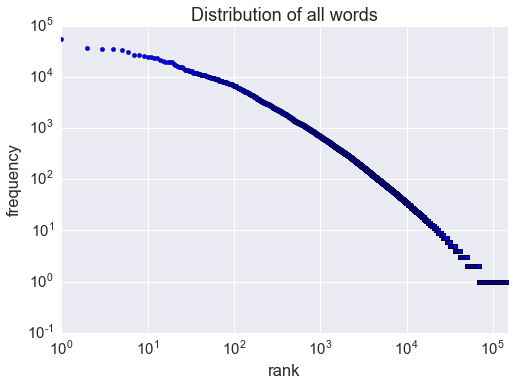

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.scatter(range(1,1+len(wcount)), wcount)
plt.loglog()
plt.xlabel('rank')
plt.ylabel('frequency')
plt.title('Distribution of all words')
plt.xlim([0, len(wcount)+1 ])

plt.savefig('words_dist_all.jpg')

We can see that it's mainly the most and the least frequency words, at the both ends of the distribution that violate the law, hence we'd like to see the plot again with these parts trimmed: 

In [24]:
def plot_truncated(cutsize):
    plt.scatter(range(cutsize+1,1+len(wcount)-cutsize), wcount[cutsize:-cutsize])
    plt.loglog()
    plt.xlabel('rank')
    plt.ylabel('#')
    plt.title('Distribution of words (top-bottom %d removed)' % cutsize)

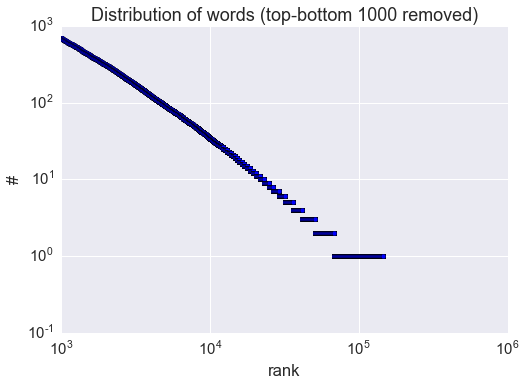

In [25]:
plot_truncated(1000)

Closer to a straight line after trimming.

## Distribution of Favorites (bookmarks)
Number of favs is one of the metrics of the popularity of an entry.

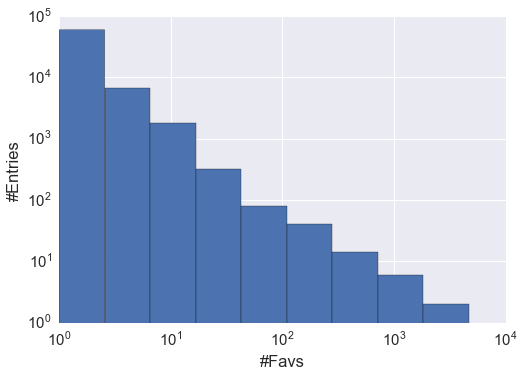

In [26]:
import numpy as np
plt.hist(entry_table['favcount'], bins=np.logspace(0, np.log10(max(entry_table['favcount'])), 10), log=True)
plt.semilogx()
plt.xlabel('#Favs')
plt.ylabel('#Entries')
plt.savefig('favs_dist.jpg')

Another distribution reminiscient of power law. One possible explanation is a preferential attachment mechanism (entries that are popular tend to be read more by others, which in turn makes them accumulate even more #favs).

## Favs vs Time

In [27]:
def get_hour(item):
    try:
        timestr = item['date_string'].split('~')[0].strip().split(' ')[-1]
        hour = int(timestr[0:2])
        minute = int(timestr[3:])
        return hour
    except:
        return np.nan

   

daytime_list = [get_hour(item) for item in items]

#Fix NaNs
prev_time = 0
for i,daytime in enumerate(list(daytime_list)):
    if np.isnan(daytime):
        daytime_list[i] = prev_time
    else:
        prev_time = daytime
    


In [28]:
entry_table['daytime'] = daytime_list

In [29]:
group_daytime = entry_table.groupby('daytime').agg(['mean','count'])
group_daytime = group_daytime.reset_index('daytime')

In [30]:
group_daytime.head()

daytime      entry_no         favcount             page_no         \
                   mean  count      mean  count         mean  count   
0       0  47199.395663  12081  3.303534  12081  4719.491847  12081   
1       1  47575.371480   8380  1.558592   8380  4757.080310   8380   
2       2  46829.647030   6043  1.499421   6043  4682.520106   6043   
3       3  45276.272338   3973  1.513718   3973  4527.175434   3973   
4       4  47211.273211   2445  1.555419   2445  4720.677710   2445   

  char_length         
         mean  count  
0  480.118947  12081  
1  443.998568   8380  
2  466.413702   6043  
3  483.627486   3973  
4  548.161963   2445

<Container object of 24 artists>

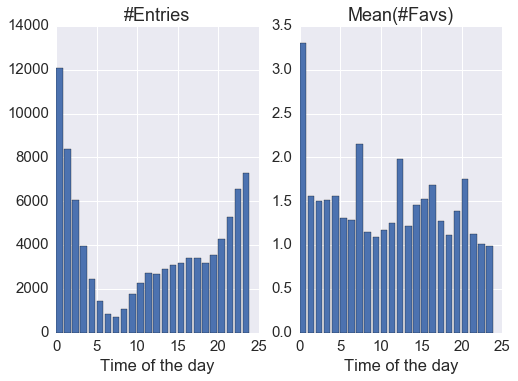

In [31]:
plt.subplot(1,2,1)
plt.xlabel('Time of the day')
plt.title('#Entries')
plt.bar(group_daytime['daytime'], group_daytime['entry_no']['count'])


plt.subplot(1,2,2)
plt.xlabel('Time of the day')
plt.title('Mean(#Favs)')
plt.bar(group_daytime['daytime'], group_daytime['favcount']['mean'])


Seems like we have the most #entries and highest #favs at midnight. This is at least partially due to the fact that entries posted around 00:00 get the highest exposure.